In [81]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [82]:
df2=pd.read_csv('df2.csv')
df2.columns

Index(['Date', 'Title', 'URL', 'sentiment', 'confidence', 'Text', 'pct',
       'pred', 'weight'],
      dtype='object')

In [83]:
sms=[]
for date, group in df2.groupby('Date'):
  cons = list(group['confidence'])
  wes = list(group['weight'])
  s = 0
  for i in range(len(cons)):
    s += cons[i]*wes[i]
  sms.append(s)

len(sms) 

765

In [84]:
df=pd.read_csv('Stock.csv')
df

,Date,Gold,Coal,Closing_price,Crude_Oil
0,2017-01-03,79035.1,305.30,498.037018,52.330002
1,2017-01-04,79721.3,306.15,487.865082,53.259998
2,2017-01-06,80321.3,306.20,491.430969,53.990002
3,2017-01-07,80321.3,306.20,492.688171,51.959999
4,2017-01-08,80321.3,306.20,492.688171,51.959999
...,...,...,...,...,...
760,2021-09-02,133121.0,134.50,2117.730469,69.989998
761,2021-09-03,133146.8,141.05,2204.584717,69.290001
762,2021-10-01,130776.3,147.60,2329.374268,75.879997
763,2021-10-02,130776.3,149.10,2359.325684,77.620003


In [85]:
min_max_scaler = MinMaxScaler()
df['Closing_price'] = min_max_scaler.fit_transform(df[['Closing_price']])
standard_scaler = StandardScaler()
df['Gold']=standard_scaler.fit_transform(df[['Gold']])
df['Coal']=standard_scaler.fit_transform(df[['Coal']])
df['Crude_Oil']=standard_scaler.fit_transform(df[['Crude_Oil']])
df

,Date,Gold,Coal,Closing_price,Crude_Oil
0,2017-01-03,-1.086089,1.359663,0.017401,-0.003241
1,2017-01-04,-1.054820,1.373258,0.012031,0.074474
2,2017-01-06,-1.027479,1.374057,0.013913,0.135477
3,2017-01-07,-1.027479,1.374057,0.014577,-0.034160
4,2017-01-08,-1.027479,1.374057,0.014577,-0.034160
...,...,...,...,...,...
760,2021-09-02,1.378535,-1.372021,0.872459,1.472518
761,2021-09-03,1.379711,-1.267264,0.918310,1.414022
762,2021-10-01,1.271690,-1.162507,0.984188,1.964716
763,2021-10-02,1.271690,-1.138517,1.000000,2.110120


In [86]:
df['Sentiments']=sms

In [87]:
df['Lag1']=df['Closing_price'].shift(1)
df=df.dropna().reset_index(drop=True)

In [88]:
def create_features(data, window,feature_cols):
    X, y = [], []
    # feature_cols = ['Gold', 'Coal','Crude_Oil','Lag1','pos','neg','neu','compound']  
    target_col = ['Closing_price']            
    max_index = len(data) - window -1
    for i in range(max_index):
        feature = data.loc[i:(i+window), feature_cols].values.astype('float32')
        target = data.loc[i+window, target_col].values.astype('float32')
        X.append(feature)
        y.append(target)
    X=np.array(X)
    y=np.array(y)    
    return X, y

In [89]:
batchsize=32
learningrate=0.001
window_size = 35

Model Architure

In [90]:

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, _) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.fc(hn)
        return out


In [91]:
def get_lstm(feature_col):
    n_epochs = 500 
    learning_rate = 0.001 

    input_size = len(feature_col)
    hidden_size = 2 
    num_layers = 1 

    num_classes = 1  

    lstm = LSTM(num_classes, 
                input_size, 
                hidden_size, 
                num_layers)

    print(lstm)            

    return lstm            

In [106]:
def training_loop(n_epochs, lstm,train_l,val_l):
    loss_fn = torch.nn.MSELoss()    
    optimiser = torch.optim.Adam(lstm.parameters(), lr=0.001)
    train_loss_a=[]
    val_loss_a=[]
    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        lstm.train()
        for inputs, targets in train_l:
            optimiser.zero_grad()
            outputs = lstm(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimiser.step()
            train_loss += loss.item() * inputs.size(0)

        lstm.eval()
        with torch.no_grad():
            for inputs, targets in val_l:
                outputs = lstm(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_l.dataset)
        val_loss /= len(val_l.dataset)
        train_loss_a.append(train_loss)
        val_loss_a.append(val_loss)

        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, train_loss, val_loss))

    return train_loss_a,val_loss_a        


In [93]:
def plot(lstm,feature_col):
    df_X_ss, df_y_mm = create_features(df,window_size,feature_col)

    df_X_ss = torch.Tensor(df_X_ss)
    df_y_mm = torch.Tensor(df_y_mm)


    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], window_size+1, df_X_ss.shape[2]))

    train_predict = lstm(df_X_ss)
    data_predict = train_predict.data.numpy()
    dataY_plot = df_y_mm.data.numpy()

    data_predict = min_max_scaler.inverse_transform(data_predict) 
    dataY_plot = min_max_scaler.inverse_transform(dataY_plot)
    true, preds = [], []
    for i in range(len(dataY_plot)):
        true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        preds.append(data_predict[i][0])

    rmse = np.sqrt(mean_squared_error(true, preds))
    print("Root Mean Squared Error (RMSE):", rmse)    
    plt.figure(figsize=(10,6)) 
    plt.axvline(x=len(df)*0.90  , c='r', linestyle='--') 

    plt.plot(true, label='Actual Data') 
    plt.plot(preds, label='Predicted Data') 
    plt.title('Stock Prediction')
    plt.legend()

    plt.show() 

Data Pre-Processing

In [94]:
def making_dataloader(x, y):
    X_tensor = torch.tensor(x)
    Y_tensor = torch.tensor(y)
    dataset = TensorDataset(X_tensor, Y_tensor)
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=False)
    return dataloader

In [95]:

train_size = int(len(df) * 0.90)
val_size = int((len(df) - train_size) * 0.50)
train = df[:train_size].reset_index(drop=True)
val= df[train_size:train_size + val_size].reset_index(drop=True)
test= df[train_size + val_size:].reset_index(drop=True)

print(f"Training Size :- {len(train)}")
print(f"Validation Size :- {len(val)}")
print(f"Testing Size :- {len(test)}")

Training Size :- 687
Validation Size :- 38
Testing Size :- 39


In [96]:
def Data(feature_col):
    X_train,y_train=create_features(train,window_size,feature_col)
    X_val,y_val=create_features(val,window_size,feature_col)
    X_test,y_test=create_features(test,window_size,feature_col)

    print(f"Shape of X Train:- {X_train.shape}")
    print(f"Shape of Y Train:- {y_train.shape}")

    train_l=making_dataloader(X_train,y_train)
    val_l=making_dataloader(X_val,y_val)
    test_l=making_dataloader(X_test,y_test)

    return train_l,val_l,test_l


In [97]:
df.columns

Index(['Date', 'Gold', 'Coal', 'Closing_price', 'Crude_Oil', 'Sentiments',
       'Lag1'],
      dtype='object')

1

In [98]:
feature_cols = ['Gold', 'Coal','Crude_Oil','Lag1','Sentiments']  


In [99]:
train_l,val_l,test_l=Data(feature_cols)
lstm=get_lstm(feature_cols)
train_loss,val_loss=training_loop(1000,lstm,train_l,val_l)


Shape of X Train:- (651, 36, 5)
Shape of Y Train:- (651, 1)
LSTM(
  (lstm): LSTM(5, 2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
Epoch: 0, train loss: 0.01625, val loss: 0.02451


Epoch: 100, train loss: 0.00320, val loss: 0.01231
Epoch: 200, train loss: 0.00239, val loss: 0.00875
Epoch: 300, train loss: 0.00170, val loss: 0.00719
Epoch: 400, train loss: 0.00268, val loss: 0.00580
Epoch: 500, train loss: 0.00202, val loss: 0.00423
Epoch: 600, train loss: 0.00087, val loss: 0.00364
Epoch: 700, train loss: 0.00107, val loss: 0.00262
Epoch: 800, train loss: 0.00032, val loss: 0.00350
Epoch: 900, train loss: 0.00029, val loss: 0.00289


Root Mean Squared Error (RMSE): 65.24101


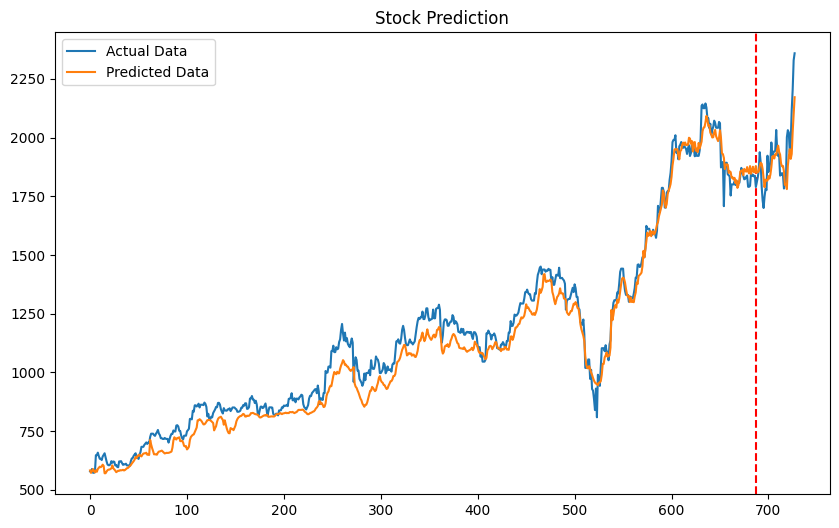

In [100]:
plot(lstm,feature_cols)

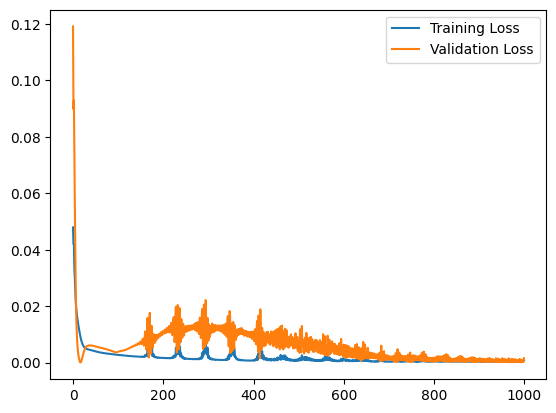

In [109]:
plt.plot(train_loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend()